# Getting Started with NBEATS and NHITS

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/Getting_Started_with_NBEATS_and_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing NeuralForecast Library

In [ ]:
%%capture
!pip install neuralforecast

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF

/home/ubuntu/miniconda/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading AirPassengers Example Data

In [ ]:
# We define the train df. 
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


## Fit NBEATS and NHITS

### Split train/test sets

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

### Fit the models

Using NeuralForecast you can fit a set of models to your dataset. You just have to define the `input_size` and `horizon` of your model. The `input_size` is the number of historic observations that the model will use to learn to predict `h` steps in the future. Also, you can modify the hyperparameters of the model to get a better accuracy.

In [ ]:
%%capture
horizon = len(Y_test_df)
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_epochs=100),
    NHITS(input_size=2 * horizon, h=horizon, max_epochs=100)
]
model = NeuralForecast(
    models=models,
    freq='M', 
)
model.fit(df=Y_train_df)

### Predict using the fitted models

In [ ]:
Y_hat_df = model.predict(horizon).reset_index()
Y_hat_df.head()

Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


,unique_id,ds,NBEATS,NHITS
0,1.0,1960-01-31,413.839722,424.264740
1,1.0,1960-02-29,396.860046,405.252869
2,1.0,1960-03-31,473.393768,464.111542
3,1.0,1960-04-30,461.116516,464.465851
4,1.0,1960-05-31,469.782074,468.644806


## Plot and Evaluate Predictions

We are going to plot the models againts the real values of test.

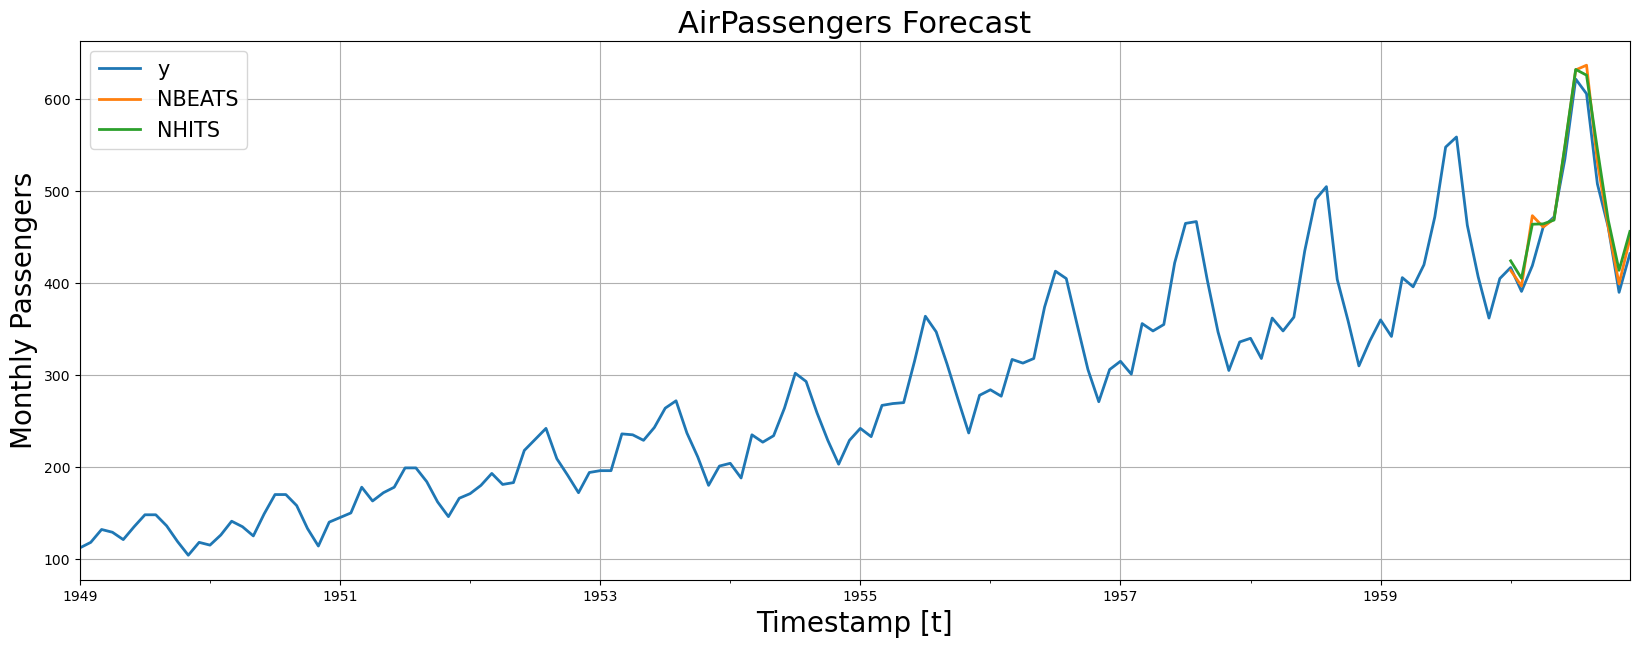

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Finally, we evaluate the predictions accuracy using the Mean Absolute Error:

$$
\qquad MAE = \frac{1}{Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}|\qquad
$$

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
nbeats_preds = Y_hat_df['NBEATS'].values
nhits_preds = Y_hat_df['NHITS'].values

print('NBEATS    MAE: %0.3f' % mae(nbeats_preds, y_true))
print('NHITS     MAE: %0.3f' % mae(nhits_preds, y_true))
print('ETS       MAE: 16.222')
print('AutoARIMA MAE: 18.551')

NBEATS    MAE: 14.110
NHITS     MAE: 17.665
ETS       MAE: 16.222
AutoARIMA MAE: 18.551


You can find [here](https://nixtla.github.io/statsforecast/examples/getting_started_with_auto_arima_and_ets.html) the reproduction of the ETS and AutoARIMA performances.

<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/Getting_Started_with_NBEATS_and_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>